# Image Segmentation Task 2

In [ ]:
!python -m pip install cityscapesscripts

### Imports

In [2]:
import os
import torch
import random
import zipfile
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

from importlib import reload
from utils import EarlyStopping
from os.path import join as pjoin
from torchvision import transforms
from networks.r2unet import R2UNet16, R2UNet64
from datasets.cityscapes import cityscapesDataset

### Setup

In [3]:
# reproducibility setups
torch.manual_seed(253452757)
random.seed(253452757)
np.random.seed(253452757)

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="6" 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Hyperparameters

In [5]:
local_path = "./Cityscapes"
bs = 5
epochs = 16
learning_rate = 0.0002
patience = 10

### Dataset and Dataloader

In [6]:
training_data = cityscapesDataset(local_path, split="train")
validation_data = cityscapesDataset(local_path, split="val")
test_data = cityscapesDataset(local_path, split="test")

Processing 5000 annotation files
Progress: 100.0 % Annotations files processed
Annotations files processed


In [11]:
dataloaders = {
    'train' : torch.utils.data.DataLoader(training_data, batch_size=bs, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(validation_data, batch_size=bs, shuffle=True, num_workers=0)
}

In [7]:
dataset_sizes = {
    'train': len(training_data),
    'val': len(validation_data),
    'test': len(test_data),
    'total': len(training_data) + len(validation_data) + len(test_data)
}

dataset_sizes

{'train': 2975, 'val': 500, 'test': 1525, 'total': 5000}

### Model setup

In [9]:
model = R2UNet64().to(device)


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

loss_f = nn.CrossEntropyLoss(ignore_index = 255)

In [ ]:
plt.imshow(training_data[1][0].permute(1, 2, 0).numpy())

### Training

In [ ]:
def train(model, epochs = epochs, opt = optimizer):
    
    model.train()
    print('Training started')
    print('-' * 10)
    
    for epoch in range(epochs):
        running_corrects = 0
        running_loss = 0.0
        
        for inputs, labels in dataloaders['train']:
            # send inputs and labels to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # reset the gradient
            opt.zero_grad()
            
            # compute loss
            outputs = model(inputs)
            loss = loss_f(outputs, labels)
            preds = torch.argmax(outputs, dim = 1)
            loss.backward()
            opt.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss/dataset_sizes['train']
        print('Epoch {}/{} - train loss = {}'.format(epoch, epochs - 1, epoch_loss))

    return model


In [ ]:
def train(model, epochs = epochs, opt = optimizer):
    
    
    print('Training started')
    print('-' * 10)
    
    #early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(epochs):
        
        model.train()
        
        running_train_loss = 0.0
        running_val_loss = 0.0
        
        for inputs, labels in dataloaders['train']:
            # send inputs and labels to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # reset the gradient
            opt.zero_grad()
            
            # compute loss
            outputs = model(inputs)
            loss = loss_f(outputs, labels)
            loss.backward()
            opt.step()
            running_train_loss += loss.item() * inputs.size(0)
            
        model.eval()
        for inputs, labels in dataloaders['val']:
            # send inputs and labels to GPU
            with torch.no_grad():
                inputs = inputs.to(device)
                labels = labels.to(device)


                # compute loss
                outputs = model(inputs)       
                loss = loss_f(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_train_loss/dataset_sizes['train']
        epoch_val_loss = running_val_loss/dataset_sizes['val']
        print('Epoch {}/{} - train loss = {}'.format(epoch, epochs - 1, epoch_train_loss))
        print('Epoch {}/{} - val loss = {}'.format(epoch, epochs - 1, epoch_val_loss))
        
        #early_stopping(epoch_val_loss, model)
        
        #if early_stopping.early_stop:
            #print("Early stopping")
            #break

    return model


In [ ]:
model = train(model, epochs)

Epoch 0/29 - train loss = 2.5089058665668262
Epoch 0/29 - val loss = 2.1309509716033936
Validation loss decreased (inf --> 2.130951).  Saving model ...
Epoch 1/29 - train loss = 1.1772558706948737
Epoch 1/29 - val loss = 1.5928427267074585
Validation loss decreased (2.130951 --> 1.592843).  Saving model ...
Epoch 2/29 - train loss = 0.8772706839617561
Epoch 2/29 - val loss = 2.3178121185302736
EarlyStopping counter: 1 out of 7
Epoch 3/29 - train loss = 0.8090069799062585
Epoch 3/29 - val loss = 1.9777345533370971
EarlyStopping counter: 2 out of 7
Epoch 4/29 - train loss = 0.7630352093792763
Epoch 4/29 - val loss = 2.31305975151062
EarlyStopping counter: 3 out of 7
Epoch 5/29 - train loss = 0.7311647877372613
Epoch 5/29 - val loss = 2.3028901195526124
EarlyStopping counter: 4 out of 7
Epoch 6/29 - train loss = 0.7086444954311146
Epoch 6/29 - val loss = 2.1918747329711916
EarlyStopping counter: 5 out of 7
Epoch 7/29 - train loss = 0.6849375997871912
Epoch 7/29 - val loss = 2.562229249954224
EarlyStopping counter: 6 out of 7
Epoch 8/29 - train loss = 0.6636786956145984
Epoch 8/29 - val loss = 2.389406723022461
EarlyStopping counter: 7 out of 7
Early stopping

Epoch 0/9 - train loss = 0.953176204396897

Epoch 1/9 - train loss = 0.7165564631213661

Epoch 2/9 - train loss = 0.6445045435128092

Epoch 3/9 - train loss = 0.5909755590583096

Epoch 4/9 - train loss = 0.4886822928150161

Epoch 5/9 - train loss = 0.3495524222860817

Epoch 6/9 - train loss = 0.3233998321435031

Epoch 7/9 - train loss = 0.30781084855063623

Epoch 8/9 - train loss = 0.28303612886356705

Epoch 9/9 - train loss = 0.26729453921067614

In [12]:
model_path = "models2/fs/15_epochs.pt"

In [ ]:
#torch.save({
            'epoch': 15,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, model_path)

In [ ]:
checkpoint = torch.load(model_path)

In [ ]:
model.load_state_dict(torch.load(os.path.join(model_path)))

In [13]:
model.load_state_dict(torch.load(os.path.join(model_path))['model_state_dict'])

<All keys matched successfully>

### Evaluate the results

In [14]:
import importlib
import evaluation
importlib.reload(evaluation)

<module 'evaluation' from '/project/evaluation.py'>

In [ ]:
f1_scores = []
dice_coefficients = []
roc_auc_scores = []

In [ ]:
true_list = []
pred_list = []
model = model.to(device)

with torch.no_grad():
    for inputs, ground_truths in dataloaders['val']:
        inputs = inputs.to(device)
        outputs = model(inputs)
        pred_list.append(torch.argmax(outputs.detach().cpu(), dim = 1))
        true_list.append(ground_truths)

true_list = torch.flatten(torch.cat(true_list))
pred_list = torch.flatten(torch.cat(pred_list))
eval_report = evaluation.EvaluationReport.from_predictions(true_list, pred_list, 
                                                               labels=list(range(19)))
f1_scores.append(eval_report.f1_score(average="macro"))
dice_coefficients.append(eval_report.dice_coeff(average="macro"))

In [ ]:
f1_scores

In [ ]:
dice_coefficients

20 epoch 64 [0.5567]


### Visualize the results

In [15]:
from utils import plot_seg_results
import importlib

In [19]:
dataloader = torch.utils.data.DataLoader(validation_data, batch_size=5, shuffle=True, num_workers=0)
images, ground_truths = next(iter(dataloader))
outputs = model(images.to(device))
predictions = torch.argmax(outputs.squeeze().cpu(), dim = 1)

In [20]:
images = [img.permute(1, 2, 0).numpy() for img in images]
predictions = [validation_data.decode_segmap(pred.numpy()) for pred in predictions]
ground_truths = [validation_data.decode_segmap(gt.numpy()) for gt in ground_truths]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


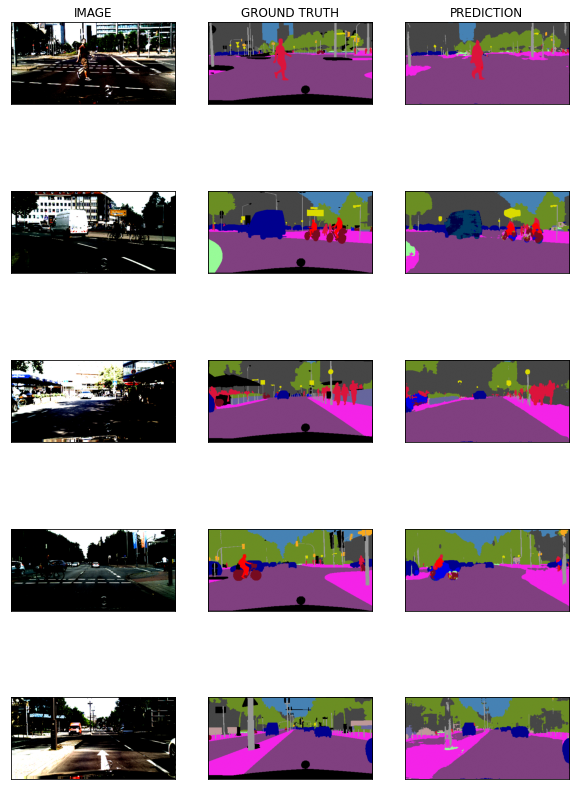

In [21]:
plot_seg_results(images, ground_truths, predictions)